In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
from itertools import combinations, chain

sys.path.append(str(Path.cwd()))

from _helpers import get_circles, generate_color_list, get_region_value

In [2]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

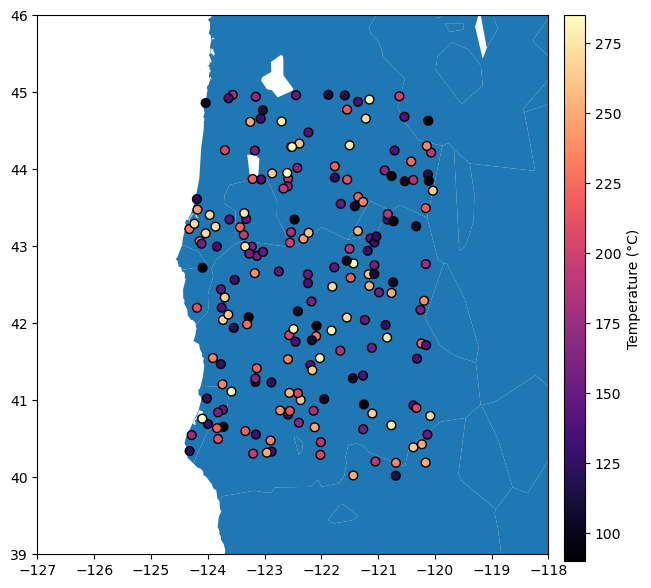

In [44]:
n = 500

t_levels = [90 + i*5 for i in range(40)]

sites = gpd.GeoDataFrame(
    {
        'demand': np.random.uniform(1, 10, n),
        'temperature': np.random.choice(t_levels, n, replace=True)
        },
    geometry=gpd.points_from_xy(
        # np.random.uniform(-130, -60, 1000),
        # np.random.uniform(25, 50, 1000)
        np.random.uniform(-130, -120, n),
        np.random.uniform(40, 45, n)
        )
    ).set_crs(epsg=4326)

# sites = sites.sjoin(usa_total, how='inner')
sites = sites.sjoin(shape, how='inner')
fig, ax = plt.subplots(figsize=(7, 7))

shape.plot(ax=ax)
sites.plot(
    ax=ax,
    # color='red',
    column='temperature',
    cmap='magma',
    edgecolor='black',
    markersize=40
    )

cax = fig.add_axes([0.9, 0.1, 0.03, 0.78])

norm = plt.Normalize(vmin=sites['temperature'].min(), vmax=sites['temperature'].max())
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
fig.colorbar(sm, cax=cax)
cax.set_ylabel('Temperature (°C)')

ax.set_xlim(-127, -118)
ax.set_ylim(39, 46)

plt.show()

In [45]:

def get_cost_evalator_cost(lower, upper, demand):
    opex_factor = 0.01
    cost = (lower + (upper - lower)) / demand
    return cost, cost * opex_factor


def get_drilling():

    default_gradient = 250 / 10
    gradient_dev = np.random.normal(1, 0.2)

    drilling_cost_factor = 100

    depth = np.arange(0, 10, 100)
    temp = default_gradient * gradient_dev * depth

    cost = drilling_cost_factor * depth

    return depth, cost, temp


In [211]:
def get_plant_capex(demand):
    return 500 + 1000 / (demand + 1)

In [30]:
def is_monotonically_decreasing(G, values):
    if isinstance(values, list):
        values = {i: values[i] for i in range(len(values))}

    start_node = max(values, key=values.get)

    prev_value = float('inf')

    for node in nx.dfs_preorder_nodes(G, start_node):
        if values[node] >= prev_value:
            return False
        prev_value = values[node]

    return True


In [32]:
# def to_peaked_graph(points, min_widths):
def get_fc_graph(points, min_widths):
    G = nx.Graph()

    for i, (x, y) in enumerate(points):
        G.add_node(
            i,
            pos=(x, y),
            min_width=min_widths[i],
            )

    for i in range(len(points)):
        for j in range(i + 1, len(points)):

            length = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            width = max(min_widths[i], min_widths[j])
            cost = length * width

            G.add_edge(i, j, weight=cost)
    
    # G = nx.minimum_spanning_tree(G, weight='weight')
    return G


def measure_graph(G):
    total = 0

    for u, v in G.edges():
        p1 = np.array(G.nodes[u]['pos'])
        p2 = np.array(G.nodes[v]['pos'])

        total += np.linalg.norm(p1 - p2)
    
    return total

In [61]:

def constrained_mst(G, temp):
    """
    Computes the Minimum Spanning Tree (MST) of a graph with an additional constraint.

    Parameters:
    - G: A NetworkX graph (assumed to be fully connected).
    - constraint_func: A function that takes (G, u, v, data) and returns True or False.

    Returns:
    - mst: A NetworkX graph representing the MST.
    """
    # Create a list of all edges with their weights
    edges = [(u, v, data) for u, v, data in G.edges(data=True)]
    # Sort edges by weight
    edges.sort(key=lambda x: x[2].get('weight', 1))

    # Initialize a new graph to store the MST
    mst = nx.Graph()
    mst.add_nodes_from(G.nodes(data=True))

    # Initialize disjoint sets for cycle detection
    parent = {node: node for node in G.nodes()}

    def find(node):
        # Find the root parent of the node
        while parent[node] != node:
            parent[node] = parent[parent[node]]  # Path compression
            node = parent[node]
        return node

    def union(u_root, v_root):
        # Merge two subsets
        parent[u_root] = v_root

    for u, v, data in edges:
        u_root = find(u)
        v_root = find(v)

        # Check if adding this edge creates a cycle
        hold = G.copy()
        hold.add_edge(u, v, **data)

        if u_root != v_root and is_monotonically_decreasing(hold, temp):
                mst.add_edge(u, v, **data)
                union(u_root, v_root)

    return mst
    

sites = np.array([
    [1, 0.],
    [0.5, 1.4],
    [0.0, 0.],
    [0.0, 1.],
    [0, 1.2],
    # [0.5, 1.3],
    # [0.0, -1],
    # [2.0, 2.],
])

n = 5
sites = np.random.uniform(0, 1, (n, 2))
temps = np.random.uniform(80, 250, n).tolist()
caps = np.random.uniform(1, 5, n).tolist()

G = get_fc_graph(sites, caps)
mst = constrained_mst(G, temps)

# Print the edges in the MST
print("Edges in the constrained MST:")
for u, v, data in mst.edges(data=True):
    print(f"{u} - {v} (weight: {data['weight']})")

Edges in the constrained MST:


In [86]:
from collections import deque
from itertools import product


def prufer_decode(prufer_sequence):
    m = len(prufer_sequence)
    n = m + 2
    degree = [1] * n

    for node in prufer_sequence:
        degree[node] += 1

    edges = []
    leaves = deque([i for i in range(n) if degree[i] == 1])

    for node in prufer_sequence:
        leaf = leaves.popleft()

        edges.append((leaf, node))

        degree[leaf] -= 1
        degree[node] -= 1

        if degree[node] == 1:
            leaves.append(node)
            leaves = deque(sorted(leaves))

    u = leaves.popleft()
    v = leaves.popleft()
    edges.append((u, v))

    return edges


def generate_all_trees(n):

    prufer_sequences = product(range(n), repeat=n-2)
    all_trees = []

    for prufer_seq in prufer_sequences:
        edges = prufer_decode(list(prufer_seq))
        all_trees.append(edges)

    return all_trees


In [181]:
def can_traverse_monotonically_decreasing(tree, values):
    max_value = max(values)
    start_nodes = [node for node, val in enumerate(values) if val == max_value]

    def dfs(current_node, current_value, visited):
        visited.add(current_node)
        for neighbor in tree.get(current_node, []):
            if neighbor not in visited and values[neighbor] <= current_value:
                dfs(neighbor, values[neighbor], visited)

    for start_node in start_nodes:
        visited = set()
        dfs(start_node, values[start_node], visited)
        if len(visited) == len(tree):
            return True

    return False

In [202]:
n = 5

sites = np.random.uniform(0, 1, (n, 2))
temps = np.random.uniform(80, 250, n).tolist()
caps = np.random.uniform(1, 5, n).tolist()



In [203]:
        
def plot_network(G, temps):
    _, ax = plt.subplots(figsize=(3, 3))

    for u, v in G.edges():
        p1 = G.nodes[u]['pos']
        p2 = G.nodes[v]['pos']

        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)

    ax.scatter(
        sites[:, 0],
        sites[:, 1],
        c=temps,
        cmap='coolwarm',
        edgecolor='black',
        linewidth=1,
        s=np.array(caps) * 30,
        )

    # ax.set_title(f'Total Pipe Cost: {total_pipe_cost:.2f}')
    plt.show()

In [204]:
def get_costoptimal_network(sites, temps, caps):

    # function to get the capacity needed for each pipe
    def compute_subtree_sums(tree, values, current_node, parent_node, edge_values):

        subtree_sum = values[current_node]
        
        for child in tree.get(current_node, []):
            if child != parent_node:

                child_subtree_sum = compute_subtree_sums(tree, values, child, current_node, edge_values)
                edge_values[(current_node, child)] = child_subtree_sum
                subtree_sum += child_subtree_sum
        
        return subtree_sum

    if isinstance(temps, np.ndarray):
        temps = list(temps)
    if isinstance(caps, np.ndarray):
        caps = list(caps)
    
    n = len(temps)
    start_node = temps.index(max(temps))

    all_trees = generate_all_trees(n)

    base = nx.Graph()
    for i, (x, y) in enumerate(sites):
        base.add_node(
            i,
            pos=(x, y),
            cap=caps[i],
            )

    keepers = []
    for tree in all_trees:
        hold = base.copy()

        for u, v in tree:
            hold.add_edge(u, v)

        if can_traverse_monotonically_decreasing(nx.to_dict_of_lists(hold), temps):
            keepers.append(tree)

    network_cost = []
    for i, tree in enumerate(keepers):
        hold = G.copy()

        for u, v in tree:
            hold.add_edge(u, v, weight=np.linalg.norm(np.array(sites[u]) - np.array(sites[v])))

        edge_values = {}
        compute_subtree_sums(
            nx.to_dict_of_lists(hold),
            caps,
            start_node,
            None,
            edge_values)

        total_pipe_cost = 0

        for edge, value in edge_values.items():
            p1 = hold.nodes[edge[0]]['pos']
            p2 = hold.nodes[edge[1]]['pos']

            total_pipe_cost += value * np.linalg.norm(np.array(p1) - np.array(p2))

        network_cost.append(total_pipe_cost)

    best_network = keepers[np.argmin(network_cost)]    

    for (u, v) in best_network:
        base.add_edge(u, v)

    return base, min(network_cost)


In [205]:
network, cost = get_costoptimal_network(sites, temps, caps)

3.5919564555694556


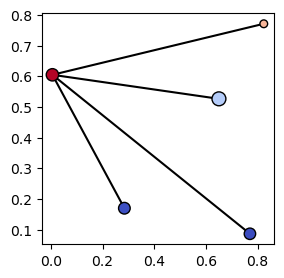

In [206]:
print(cost)
plot_network(network, temps)

In [144]:
print(hold.edges())
print(edge_values)
print(temps)

[(0, 1), (0, 2), (0, 3), (0, 4)]
{(0, 1): 4.236082671970658, (0, 2): 1.6899154086338193, (0, 3): 2.1774763782649114, (4, 0): 9.292883350816627}
{0: 204.0613412990163, 1: 95.85556495317263, 2: 123.92120618393511, 3: 153.92664181270268, 4: 244.731789260548}


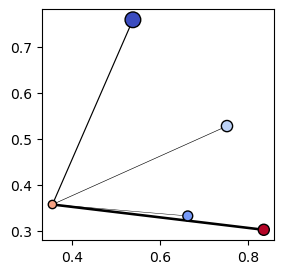

In [151]:
for tree in keepers:

    hold = G.copy()
    fig, ax = plt.subplots(figsize=(3, 3))
    for u, v in tree:
        hold.add_edge(u, v, weight=np.linalg.norm(np.array(sites[u]) - np.array(sites[v])))

    for u, v in hold.edges():
        p1 = hold.nodes[u]['pos']
        p2 = hold.nodes[v]['pos']

        try:
            ev = edge_values[(u, v)]
        except KeyError:
            ev = edge_values[(v, u)]
        
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1, linewidth=ev / 5)

    ax.scatter(
        sites[:, 0],
        sites[:, 1],
        c=list(temps.values()),
        cmap='coolwarm',
        edgecolor='black',
        linewidth=1,
        s=np.array(caps) * 30,
        )

    plt.show()

In [8]:
def get_partitions(elements):

    def get_naive_partitions(elements):
        if not elements:
            return [[]]

        result = []
        for i in range(1, len(elements) + 1):
            for combo in combinations(elements, i):
                remaining_elements = [e for e in elements if e not in combo]
                for rest in get_naive_partitions(remaining_elements):
                    result.append([tuple(combo)] + rest)
        
        return result


    all_partitions = get_naive_partitions(elements)

    def remove_permutations(lst):
        seen = list()
        cleaned_list = []

        for element in lst:
            sorted_element = sorted(element)

            if sorted_element not in seen:
                cleaned_list.append(element)
                seen.append(sorted_element)

        return cleaned_list


    return remove_permutations(all_partitions)

In [209]:
from shapely.geometry import MultiPoint


def get_heat_network(xy: np.array, temps: list, caps: list, pipe_price: float):
    
    assert len(xy) == len(temps), 'Length of xy and temperatures must be the same'
    assert len(xy) == len(caps), 'Length of xy and capacities must be the same'
    if len(xy):
        assert xy.shape[1] == 2
    
    if not isinstance(temps, list):
        temps = temps.tolist()
    if not isinstance(caps, list):
        caps = caps.tolist()
    n = xy.shape[0]

    if n == 1:

        return caps[0], get_plant_capex(np.array(caps))

    else:

        if n == 2:

            # well placement will always just be at larger hotter demand site; redundant approach?
            well_proposals = gpd.GeoSeries(
                gpd.points_from_xy(
                np.linspace(xy[0, 1], xy[1, 1], 2),
                np.linspace(xy[0, 0], xy[1, 0], 2)
                )
            )

        else:

            num_well_test_sqrt = 10

            xrange = np.linspace(xy[:, 1].min(), xy[:, 1].max(), num_well_test_sqrt)
            yrange = np.linspace(xy[:, 0].min(), xy[:, 0].max(), num_well_test_sqrt)

            well_proposals = gpd.GeoSeries(
                gpd.points_from_xy(
                np.stack([xrange for _ in range(num_well_test_sqrt)], axis=1).flatten(),
                np.stack([yrange for _ in range(num_well_test_sqrt)], axis=1).T.flatten(),
                )
            )

            hull = MultiPoint(xy[:,::-1]).convex_hull
            well_proposals = (
                well_proposals
                .loc[well_proposals.within(hull)]
            )

        pipe_lengths, well_xs, well_ys = [], [], []

        for well in well_proposals:

            well_coords = np.array(well.coords)[0][::-1]

            layout = (
                np.vstack([xy, well_coords])
            )

            G, pipe_volume = get_costoptimal_network(layout, temps + [max(temps) + 1], caps + [0])

            '''
            _, ax = plt.subplots(figsize=(3, 3))
            for u, v in G.edges():
                p1 = G.nodes[u]['pos']
                p2 = G.nodes[v]['pos']
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', zorder=1)
            ax.scatter(layout[:, 0], layout[:, 1], c=temps + [max(temps) + 1], cmap='magma', edgecolor='black', linewidth=1)
            plt.show()
            '''

            well_xs.append(well_coords[1])
            well_ys.append(well_coords[0])
            pipe_lengths.append(pipe_volume)

        if not pipe_lengths:
            return np.nan

        results = pd.DataFrame({
            'pipe_lengths': pipe_lengths,
            'well_xs': well_xs,
            'well_ys': well_ys
        })

        results = results.sort_values('pipe_lengths').iloc[0]
        pipe_cost = results.loc['pipe_lengths'] / 360 * 6371 * pipe_price

        return pipe_cost + get_plant_capex(sum(caps))



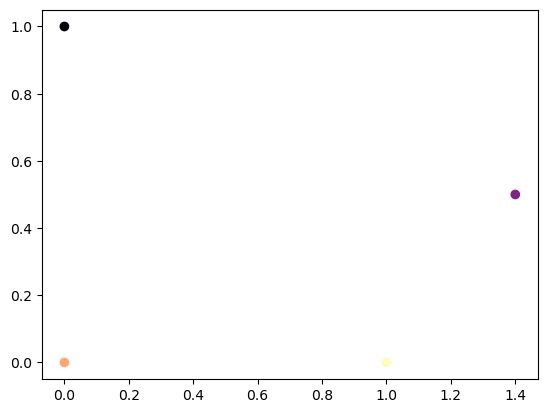

In [212]:
sites = np.array([
    [1, 0.],
    [0.5, 1.4],
    [0.0, 0.],
    [0.0, 1.],
])
temps = [100, 140, 190, 210]
caps = [4, 2, 3, 4]

get_heat_network(sites, temps, caps, 0.1)
plt.scatter(sites[:, 1], sites[:, 0], c=temps, cmap='magma')

[(0,), (1,)]
[[  41.23803236 -123.1605025 ]
 [  41.28316888 -123.16090465]]
[[[  41.23803236 -123.1605025 ]]]
[[  41.23803236 -123.1605025 ]]
(0,)
10     105
130    165
Name: temperature, dtype: int32
[105]


SystemExit: 

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


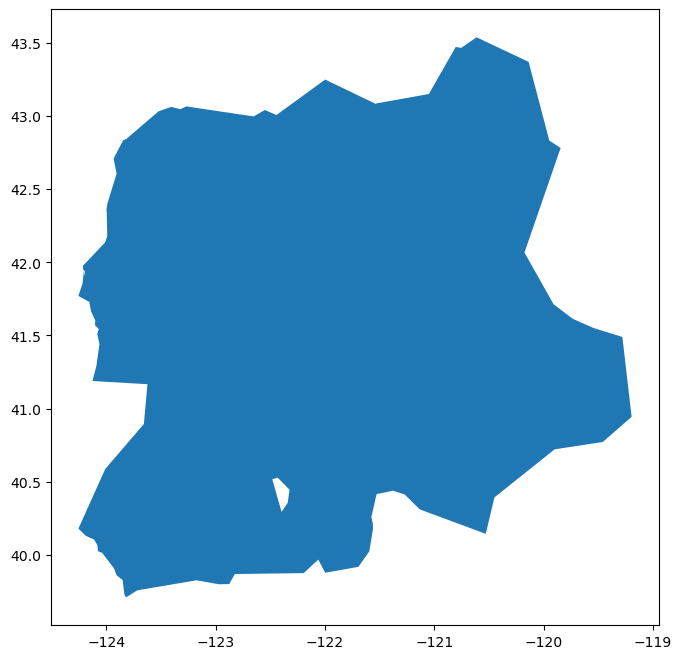

In [57]:
from shapely.geometry import MultiPoint
from sklearn.metrics.pairwise import haversine_distances


pipe_price = 100

threshold_distance_km = 10
threshold_distance_rad = threshold_distance_km / 6371.0


for index_right in sites.index_right.value_counts().index:

    ss = sites.loc[sites.index_right == index_right]

    if ss.empty:
        continue

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    shape.loc[[index_right]].plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    caps, capex, cluster_size = [], [], []

    for k, col in zip(unique_labels, colors):

        class_member_mask = (labels == k)

        xy = sites_np[class_member_mask]
        size = ss.iloc[class_member_mask]['demand']
        temps = ss.iloc[class_member_mask]['temperature']

        if k == -1:
            col = [0, 0, 0, 1]

            caps.extend(size)
            capex.extend(get_plant_capex(np.array(size)))
            cluster_size.extend([1] * len(size))

        else:
            partitions = get_partitions(list(range(len(xy))))
            partition_costs = []
            disagg_partition_costs = []

            partition_caps = []
            partition_cluster_sizes = []

            for i, partition in enumerate(partitions):

                n_cost = []
                n_caps = []
                n_cluster_size = []

                # partition discarded if no monotonically decreasing
                # temperature levels are found
                partition_eligible = False 

                print(partition)

                for n_idx in partition:

                    n_xy = xy[[n_idx]][0]
                    n_temp = temps.iloc[list(n_idx)].tolist()

                    print(xy)
                    print(xy[[n_idx]])
                    print(n_xy)
                    print('==========')
                    print(n_idx)
                    print('==========')
                    print(temps)
                    print(n_temp)

                    import sys
                    sys.exit()

                    n_size = size.iloc[list(n_idx)]
                    n_cluster_size.append(len(n_idx))

                    if len(n_size) == 1:

                        n_caps.extend(n_size)
                        n_cost.extend(get_plant_capex(np.array(n_size)))

                    else:

                        num_well_test_sqrt = 10

                        if len(n_size) == 2:

                            # cost-optimal well placement will always just be at larger demand site; redundant approach?
                            well_proposals = gpd.GeoSeries(
                                gpd.points_from_xy(
                                np.linspace(n_xy[0, 1], n_xy[1, 1], 2),
                                np.linspace(n_xy[0, 0], n_xy[1, 0], 2)
                                )
                            )

                        else:

                            xrange = np.linspace(n_xy[:, 1].min(), n_xy[:, 1].max(), num_well_test_sqrt)
                            yrange = np.linspace(n_xy[:, 0].min(), n_xy[:, 0].max(), num_well_test_sqrt)

                            well_proposals = gpd.GeoSeries(
                                gpd.points_from_xy(
                                np.stack([xrange for _ in range(num_well_test_sqrt)], axis=1).flatten(),
                                np.stack([yrange for _ in range(num_well_test_sqrt)], axis=1).T.flatten(),
                                )
                            )

                            hull = MultiPoint(n_xy[:,::-1]).convex_hull
                            well_proposals = (
                                well_proposals
                                .loc[well_proposals.within(hull)]
                            )

                        pipe_lengths, well_xs, well_ys = [], [], []

                        for well in well_proposals:

                            well_coords = np.array(well.coords)[0][::-1]
                            well_xs.append(well_coords[1])
                            well_ys.append(well_coords[0])

                            layout = (
                                np.vstack([n_xy, well_coords])
                            )

                            G = to_peaked_graph(
                                    layout,
                                    n_size.tolist() + [0]
                            )

                            # is_monotonically_decreasing(G, values):


                            pipe_lengths.append(measure_graph(G))

                        results = pd.DataFrame({
                            'pipe_lengths': pipe_lengths,
                            'well_xs': well_xs,
                            'well_ys': well_ys
                        })

                        assert not results.empty

                        results = results.sort_values('pipe_lengths').iloc[0]
                        pipe_cost = results.loc['pipe_lengths'] / 360 * 6371 * pipe_price

                        total_cost = pipe_cost + get_plant_capex(n_size.sum())

                        n_cost.append(total_cost)
                        n_caps.append(n_size.sum())


                partition_costs.append(sum(n_cost))
                disagg_partition_costs.append(n_cost)
                partition_caps.append(n_caps)
                partition_cluster_sizes.append(n_cluster_size)

            print('partition_costs')
            print(partition_costs)
            print(disagg_partition_costs)
            print(np.argmin(partition_costs))

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_disagg_partition_costs = disagg_partition_costs[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            '''
            print('partition_costs')
            print(partition_costs)

            print('best_partition')
            print(best_partition)
            print('disagg_partition_costs')
            print(disagg_partition_costs)
            print('best_partition_caps')
            print(best_partition_caps)
            print('best_partition_cluster_sizes')
            print(best_partition_cluster_sizes)
            '''

            # caps.append(size.sum())
            # capex.append(total_cost)
            # cluster_size.append(len(size))
            # caps.append(size.sum())
            # capex.append(total_cost)
            # cluster_size.append(len(size))

            for ca, co, cl in zip(
                best_partition_caps,
                best_disagg_partition_costs,
                best_partition_cluster_sizes
                ):

                caps.append(ca)
                capex.append(co)
                cluster_size.append(cl)

            '''
            print('size')
            print(size)
            print('capex')
            print(total_cost)
            print('cluster_size')
            print(len(size))
            '''
            # print('-----------------------------------')

        ax.scatter(
            xy[:, 1],
            xy[:, 0],
            color=tuple(col),
            edgecolor='k',
            alpha=1,
            s=size*20
            )


    ax.set_title(f'Estimated number of clusters: {n_clusters}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
    # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)
    plt.show()
    break

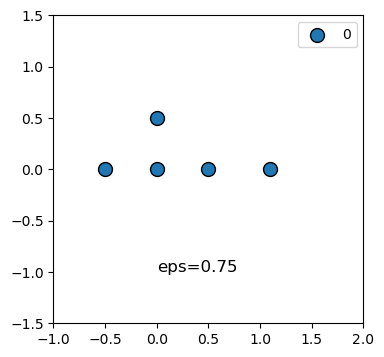

In [164]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree

pts = np.array([
    [-0.5, 0.],
    [0., 0.],
    [0.5, 0.],
    [0.0, 0.5],
    [1.1, 0.],
])

db = DBSCAN(
    eps=0.75,
    min_samples=2,
    metric='haversine').fit(pts)

db.labels_

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for label in np.unique(db.labels_):
    ax.scatter(
        pts[db.labels_ == label, 0],
        pts[db.labels_ == label, 1],
        label=label,
        s=100,
        edgecolor='k',
        )

ax.set_xlim(-1, 2)
ax.set_ylim(-1.5, 1.5)
ax.text(0, -1., 'eps=0.75', fontsize=12)

ax.legend()
plt.show()


In [64]:
region_df = pd.DataFrame({
    'caps': caps,
    'capex': capex,
    'cluster_size': cluster_size
}).sort_values('capex')

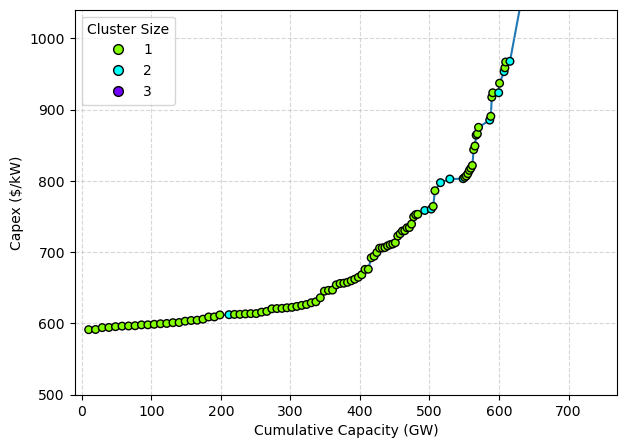

In [65]:
region_df['cumcap'] = region_df['caps'].cumsum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(region_df['cumcap'], region_df['capex'], zorder=1)

color_list = generate_color_list(max(region_df['cluster_size']) + 1)
c = [color_list[i] for i in region_df['cluster_size']]

ax.scatter(region_df['cumcap'], region_df['capex'], c=c, s=30, edgecolor='k', zorder=2)
ax.set_xlabel('Cumulative Capacity (GW)')
ax.set_ylabel('Capex ($/kW)')

ax.set_xlim(-10, 770)
ax.set_ylim(500, 1040)
ax.grid(True, linestyle='--', alpha=0.5)

labels = region_df['cluster_size'].unique()
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
               markeredgecolor='k', label=f'{i} sites')
           for i in labels]

ax.legend(handles, labels, title='Cluster Size', loc='upper left')


plt.show()

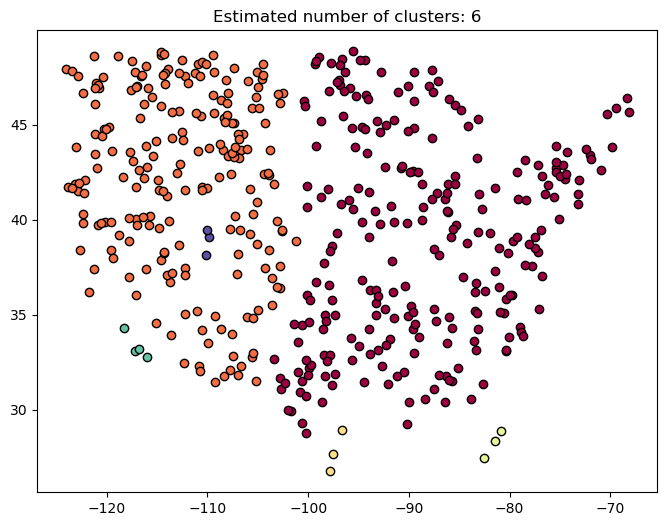

In [13]:
threshold_distance = 2

# Perform DBSCAN clustering
db = DBSCAN(eps=threshold_distance, min_samples=2).fit(sites_np)
labels = db.labels_


# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = sites_np[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.show()


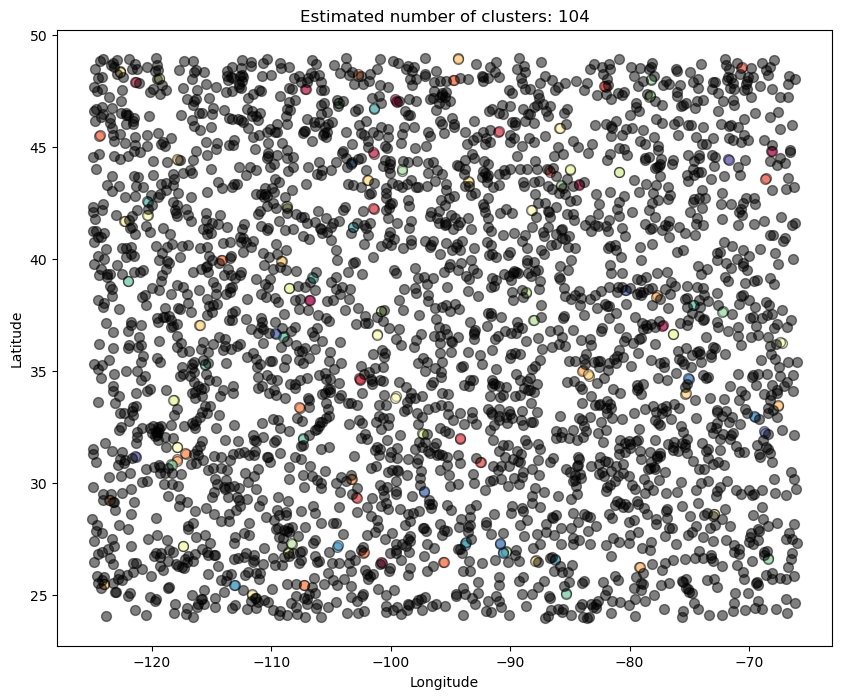

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

latitudes = np.random.uniform(low=24, high=49, size=3000)
longitudes = np.random.uniform(low=-125, high=-66, size=3000)
sites = np.vstack((latitudes, longitudes)).T

# Define the maximum distance for a cluster in kilometers
threshold_distance_km = 10

# Convert the threshold distance from kilometers to radians (for use with geodesic distance)
threshold_distance_rad = threshold_distance_km / 6371.0  # Earth's radius in km

# Perform DBSCAN clustering based on geographical distance
db = DBSCAN(eps=threshold_distance_rad, min_samples=2, metric='haversine').fit(np.radians(sites))
labels = db.labels_

# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plotting the results (not geographically accurate but illustrative)
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = sites[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0], color=tuple(col), edgecolor='k', s=50, alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


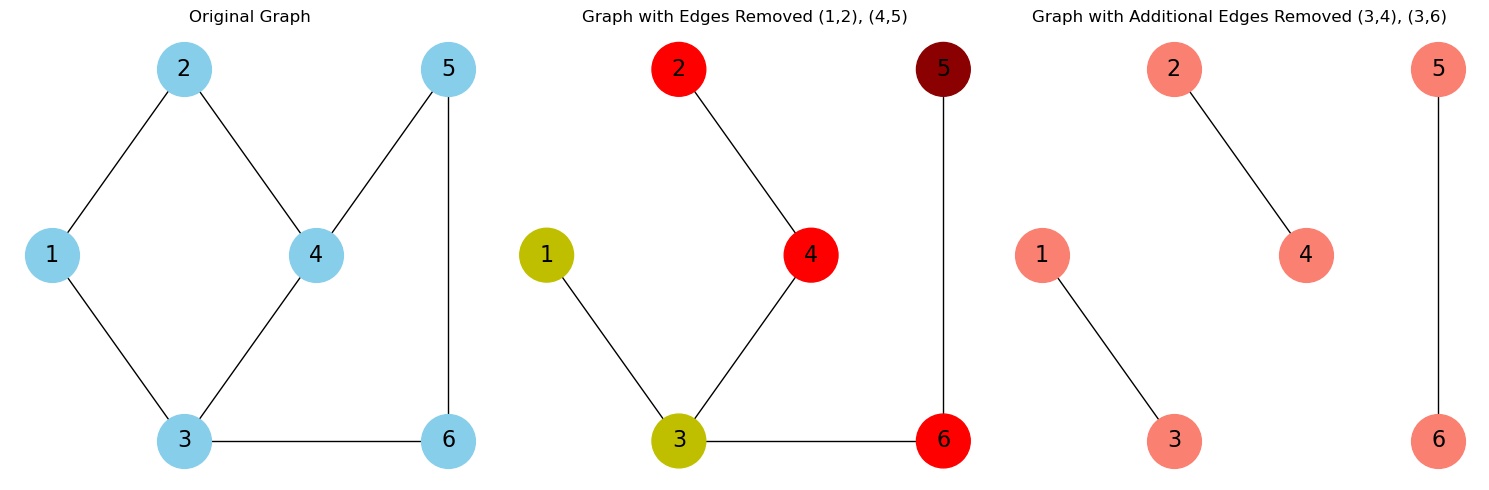

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the initial graph
G = nx.Graph()

# Add nodes
nodes = [1, 2, 3, 4, 5, 6]
G.add_nodes_from(nodes)

# Add edges
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6), (3, 6)]
G.add_edges_from(edges)

# Define fixed positions for the nodes
fixed_positions = {
    1: (0, 2),
    2: (1, 3),
    3: (1, 1),
    4: (2, 2),
    5: (3, 3),
    6: (3, 1)
}

# Plot 1: Original Graph
plt.figure(figsize=(15, 5))
plt.subplot(131)  # 1 row, 3 columns, 1st subplot
nx.draw(G, pos=fixed_positions, with_labels=True, node_color='skyblue', edge_color='black', node_size=1500, font_size=16)
plt.title("Original Graph")

# Plot 2: Remove some edges and plot
G2 = G.copy()
edges_to_remove_2 = [(1, 2), (4, 5)]
G2.remove_edges_from(edges_to_remove_2)

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
nx.draw(G2, pos=fixed_positions, with_labels=True, node_color=['y', 'r', 'y', 'r', 'darkred', 'r'], edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Edges Removed (1,2), (4,5)")

# Plot 3: Remove more edges and plot
G3 = G2.copy()
edges_to_remove_3 = [(3, 4), (3, 6)]
G3.remove_edges_from(edges_to_remove_3)

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
nx.draw(G3, pos=fixed_positions, with_labels=True, node_color='salmon', edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Additional Edges Removed (3,4), (3,6)")

# Show all plots
plt.tight_layout()
plt.show()
